In [222]:
from __future__ import division
import os
import urllib, cStringIO
import pymongo as pm ## first establish ssh tunnel to server where database is running
import base64
import numpy as np
from numpy import *
import PIL
from PIL import Image
import base64
import matplotlib
%matplotlib inline
from matplotlib import pylab, mlab, pyplot
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches

import pandas as pd
from svgpathtools import parse_path

#### directory and file hierarchy

In [2]:
# directory & file hierarchy
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    

import sys
## add helpers to python path
if os.path.abspath(os.getcwd()) not in sys.path:
    sys.path.append(os.path.abspath(os.getcwd()))
    
import svg_distance_helpers as rsh
reload(rsh)

<module 'svg_distance_helpers' from 'svg_distance_helpers.pyc'>

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['cdm_run_v3']

#### fetch an example tracing

In [4]:
imrecs = coll.find({'$and':[{'category':'square'},{'dataType':'finalImage'}]}).sort('time')
print imrecs.count()

## retrieve example square tracing from db
imrec = imrecs[90] 

2493


In [5]:
## get list of vertices and codes for tracing 
try:
    ## get the corresponding stroke records for this tracing
    stroke_recs = coll.find({'$and': [{'sessionId':imrec['sessionId']}, 
                                      {'dataType':'stroke'},
                                      {'trialNum': imrec['trialNum']}]}).sort('time')

    print 'Number of strokes in this tracing: {}'.format(stroke_recs.count())    
    
    ## check to make sure that there is at least one stroke! 
    if stroke_recs.count()>0:

        ## now make an svg list!
        svg_list = rsh.make_svg_list(stroke_recs)

        ## now get me some verts and codes!
        __Verts, __Codes = rsh.get_verts_and_codes(svg_list)
        
except Exception as e:
    print 'Oops, something went wrong! Here is the error:'  
    print e
    pass        

Number of strokes in this tracing: 1


#### preprocessing of tracing and visualization (if desired)

In [24]:
## simplify tracing a bit if it is a jungle of verts/horiz commands
_Verts,_Codes = rsh.simplify_verts_and_codes(__Verts,__Codes)

In [25]:
## make sure the last vertex of the tracing 
## is equal to the first vertex so the
## polygon centroid formula works
if np.sum(_Verts[-1] - _Verts[0]) != 0:
    _Verts = np.vstack((_Verts,_Verts[0]))
    _Codes.append(2)

In [26]:
## examine tracing
reallyRun = 0
if reallyRun:
    rsh.plot_shape(_Verts,_Codes)

In [27]:
## get vertices and codes for reference shape (in this example, a square)
Verts, Codes = rsh.get_nearest_reference_square_to_tracing(_Verts,_Codes)

In [28]:
## examine reference shape (in this example, a square)
reallyRun = 0
if reallyRun:
    rsh.plot_shape(Verts,Codes)

In [29]:
## get centroid of both shapes
ref_cx,ref_cy = rsh.get_centroid_polygon(Verts)
tra_cx,tra_cy = rsh.get_centroid_polygon(_Verts)

ref_centroid = np.array((ref_cx,ref_cy))
tra_centroid = np.array((tra_cx,tra_cy))

In [30]:
print ref_cx,ref_cy
print tra_cx,tra_cy

411.49999999999994 405.67188
412.20421909124275 406.9746849046484


In [31]:
## get verts and codes for the reference and tracing
ref_verts = Verts-ref_centroid
ref_codes = Codes
tra_verts = _Verts-tra_centroid
tra_codes = _Codes

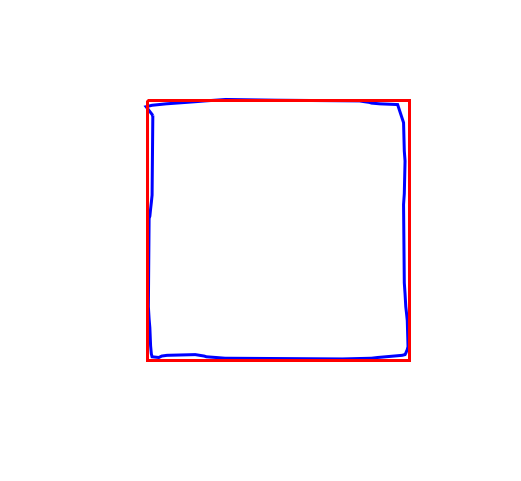

In [58]:
rsh.plot_coregistered_shapes(ref_verts,ref_codes,tra_verts,tra_codes)

#### test case for particular line segment AB on reference shape and point P on tracing

In [249]:
A = np.array((0,0))
B = np.array((10,10))
P = np.array((20,5)) ## first point

## get point C on A,B that minimizes distance from particular point on tracing to the line segment AB
C = rsh.get_closest_point_from_P_to_AB(A,B,P,verbose=False) 

In [ ]:
a = ref_verts[0]
b = ref_verts[1]
p = tra_verts[1]
c,d = rsh.get_closest_point_from_P_to_AB(a,b,p,verbose=False) 
print c,d

#### get corresponding points on the reference shape for each vertex in the tracing

In [56]:
cor_verts = np.zeros((np.shape(tra_verts)[0],2))
for i,t in enumerate(tra_verts): ## loop through segments of the tracing
    p = t ## endpoint of the current tracing segment
    ## for a given point on the tracing, find the corresponding closest point on the reference shape
    ref_gen = rsh.pairs(ref_verts)
    D = 1e6 ## initialize at some crazy large value
    for r in ref_gen:
        a = r[0]
        b = r[1]
        c,d = rsh.get_closest_point_from_P_to_AB(a,b,p,verbose=False) 
        if d<D: ## if the shortest distance so far, then swap in for the value of D
            D = d
            C = c
        else:
            pass 
    cor_verts[i,:] = C ## assign the closest corresponding point to the "corresponding vertices" array

In [61]:
## test to make sure the corresponding points really lie on the reference shape
reload(rsh)
reallyRun = 0
if reallyRun:
    rsh.plot_corresponding_points_on_reference(tra_verts,tra_codes,ref_verts,ref_codes,cor_verts)

In [62]:
A = np.array((0,0))
B = np.array((10,10))
P = np.array((5,5)) ## first point

## get point C on A,B that minimizes distance from particular point on tracing to the line segment AB
C = rsh.get_closest_point_from_P_to_AB(A,B,P,verbose=False) 
print C

(array([5., 5.]), 0.0)


In [259]:
def near(a, b, rtol=1e-5, atol=1e-8):
    return abs(a - b) < (atol + rtol * abs(b))

def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

def line_intersection(line1, line2,verbose=False):    
    '''
    see: https://stackoverflow.com/questions/15297590/improve-in-coding-saving-how-to-check-if-two-line-segments-are-crossing-in-pytho
    
    Return the coordinates of a point of intersection given two lines.
    Return None if the lines are parallel, but non-collinear.
    Return an arbitrary point of intersection if the lines are collinear.

    Parameters:
    line1 and line2: lines given by 2 points (a 2-tuple of (x,y)-coords).    
    '''
    collinear = False
    (x1,y1), (x2,y2) = line1
    (u1,v1), (u2,v2) = line2
    (a,b), (c,d) = (x2-x1, u1-u2), (y2-y1, v1-v2)
    e, f = u1-x1, v1-y1
    # Solve ((a,b), (c,d)) * (t,s) = (e,f)
    denom = float(a*d - b*c)
    if near(denom, 0):
        # parallel
        # If collinear, the equation is solvable with t = 0.
        # When t=0, s would have to equal e/b and f/d
        try:
            if (b==0): ## lines are both vertical, check if collinear
                ## https://math.stackexchange.com/questions/1102258/how-to-determine-if-some-line-segments-are-collinear 
                ## Three points are collinear if the determinant 
                ## (see below) is zero
                if near(x1*y2 + x2*v1 + u1*y1 - x1*v1 - x2*y1 - u1*y2,0):
                    if verbose==True:
                        print 'vertical, parallel and collinear'
                        collinear=True
                        return collinear
                else:
                    if verbose==True:
                        print 'vertical, parallel but not collinear'
                        return None
            elif d==0: ## lines are both horizontal, check if collinear
                if near(x1*y2 + x2*v1 + u1*y1 - x1*v1 - x2*y1 - u1*y2,0):
                    if verbose==True:                        
                        print 'horizontal, parallel and collinear' 
                        collinear=True                                                
                        return collinear
                else:
                    if verbose==True:
                        print 'horizontal, parallel but not collinear'  
                        return None
            elif near(float(e)/b, float(f)/d):
                # collinear
                px = x1
                py = y1
                collinear=True  
                print 'point of intersection returned'                
                return px, py, collinear
            else:
                if verbose==True:
                    print 'neither horizontal nor vertical, but parallel and non-collinear'
                    return None
        except:
            print 'Case unknown'
            
    else:
        t = (e*d - b*f)/denom
        # s = (a*f - e*c)/denom
        px = x1 + t*(x2-x1)
        py = y1 + t*(y2-y1)
        return px, py
    
def check_if_intersection_on_line_segments(x1,y1,x2,y2,u1,v1,u2,v2,px,py,verbose=False):    
    ## check if segments intersect at a point within the line segments
    ## if within, then go ahead and increment error by adding the triangles
    ## if outside, increment error as trapezoid
    A = np.array((x1,y1))
    B = np.array((x2,y2))
    P = np.array((px,py))
    C, dist1 = rsh.get_closest_point_from_P_to_AB(A,B,P,verbose=False)
    A = np.array((u1,v1))
    B = np.array((u2,v2))
    P = np.array((px,py))
    C, dist2 = rsh.get_closest_point_from_P_to_AB(A,B,P,verbose=False)

    if (near(dist1,0)) or (near(dist2,0)):
        if verbose==True:
            print 'point of intersection is on the line segment'
        return px,py
    else:
        return None    

In [260]:
def get_area_between_tracing_and_corresponding_verts(tra_verts,cor_verts,verbose=False):
    total_error = 0
    tra_gen = rsh.pairs(tra_verts)
    cor_gen = rsh.pairs(cor_verts)
    for i,t in enumerate(zip(tra_gen,cor_gen)):

        tra_vert_1 = tuple(t[0][0]) ## tra vert 1
        tra_vert_2 = tuple(t[0][1]) ## tra vert 2
        cor_vert_1 = tuple(t[1][0]) ## cor vert 2
        cor_vert_2 = tuple(t[1][1]) ## cor vert 2
        line1 = tuple((tra_vert_1,tra_vert_2))
        line2 = tuple((cor_vert_1,cor_vert_2))

        ## determine whether these two segments intersect
        out = line_intersection(line1,line2,verbose=True)

        if type(out)==bool:
            if verbose==True:
                print 'segments are collinear, do not increment error'
            this_error = 0
        elif (type(out)==tuple):
            px,py = out
            (x1,y1), (x2,y2) = line1
            (u1,v1), (u2,v2) = line2
            check = check_if_intersection_on_line_segments(x1,y1,x2,y2,u1,v1,u2,v2,px,py,verbose=verbose)        
            if check==None:
                if verbose==True:
                    print 'segments do not intersect, increment error by whole trapezoid'            
                trapezoid_verts = [(x1,y1),(x2,y2),(u1,v1),(u2,v2),(x1,v1)]
                area = rsh.get_area_polygon(trapezoid_verts)
                this_error = np.abs(area)
            elif type(check)==tuple:
                if verbose==True:                
                    print 'segments do intersect, increment error by two triangles'            
                px,py = check            
                triangle_verts_1 = [(x1,y1),(px,py),(u1,v1),(x1,y1)]
                triangle_verts_2 = [(px,py),(u2,v2),(x2,y2),(px,py)]
                area1 = rsh.get_area_polygon(triangle_verts_1)
                area2 = rsh.get_area_polygon(triangle_verts_2)    
                this_error = np.abs(area1) + np.abs(area2) 
        elif out==None:
            if verbose==True:            
                print 'segments are parallel (but not collinear), increment error'
            trapezoid_verts = [(x1,y1),(x2,y2),(u1,v1),(u2,v2),(x1,v1)]
            area = rsh.get_area_polygon(trapezoid_verts)
            this_error = np.abs(area)

        ## increment total_error by this_error
        total_error += this_error
    return total_error



In [261]:
total_error = get_area_between_tracing_and_corresponding_verts(tra_verts,cor_verts)

In [262]:
np.sqrt(total_error)

80.69591317900604